<a href="https://colab.research.google.com/github/KimRass/Programming/blob/master/Data%20Science/Machine%20Learning/Time%20Series/Ethereum%20%26%20DeepAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling-&amp;-Training" data-toc-modified-id="Modeling-&amp;-Training-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling &amp; Training</a></span></li><li><span><a href="#Inference" data-toc-modified-id="Inference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Inference</a></span></li></ul></div>

In [1]:
# Data Science/Machine Learning/Time Series/Ethereum & DeepAR.ipynb

from google.colab import drive
import os
drive.mount("/content/drive")
os.chdir("/content")

import numpy as np
import tensorflow_probability as tfp
import pandas as pd
from datetime import datetime, timedelta
from numpy import array
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, GroupKFold, LeaveOneOut, LeaveOneGroupOut
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D, RepeatVector
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adagrad, Adam
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
from tensorflow.keras.initializers import RandomNormal, glorot_uniform, he_uniform, Constant

plt.style.use("dark_background")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
os.chdir("/content/drive/MyDrive/TS")
data = pd.read_csv("./Datasets/Ethereum/ETH_USD.csv", skiprows=1, parse_dates=["Date"], index_col="Date")

data = data.drop(["Symbol","Unix Timestamp"] , axis=1)
data = data.sort_index()

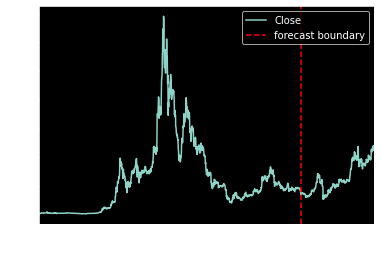

In [3]:
test_size = 360
cutoff = data.index.max() - timedelta(days=test_size)
data_tr, data_te = train_test_split(data["Close"], test_size=test_size, shuffle=False)

data["Close"].plot.line();
plt.axvline(x=cutoff, c="red", ls="--", label="forecast boundary");
plt.legend();

In [4]:
# Feature Scaling
mean_tr = data_tr.mean()
std_tr = data_tr.std()
tr_sc = (data_tr - mean_tr)/std_tr

mean_te = data_te.mean()
std_te = data_te.std()
te_sc = (data_te - mean_te)/std_te

In [5]:
def blocked_cv(data, window_size, h):
    X = list()
    y = list()
    for i in range(len(data) - window_size - h + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + h])
    return np.array(X), np.array(y)

window_size = 30
h = 1
tr_X, tr_y = blocked_cv(tr_sc, window_size, h)
tr_X = tr_X[:, :, None]
tr_y = tr_y[:, :, None]

te_X, te_y = blocked_cv(te_sc, window_size, h)
te_X = te_X[:, :, None]

# Modeling & Training

In [ ]:
def normal_log_pdf(mu, sigma, y):
    tfd = tfp.distributions
    dist = tfd.Normal(loc=mu, scale=sigma)
    log_prob = dist.log_prob(y)
    return -tf.reduce_sum(log_prob)

lstm_units = 1024
epochs = 10000
optimizer = Adam()
metrics = RootMeanSquaredError()
for epoch in range(1, epochs + 1):
    with tf.GradientTape() as tape:
        inputs = Input(shape=(window_size, 1))

        z = LSTM(units=lstm_units, return_sequences=True)(inputs)
        z = LSTM(units=lstm_units, return_sequences=True)(z)
        z = LSTM(units=lstm_units, return_sequences=True)(z)
        z = LSTM(units=lstm_units, return_sequences=True)(z)

        outputs = [Dense(units=1)(z), Dense(units=1, activation="softplus")(z)]

        model = Model(inputs=inputs, outputs=outputs)
        
        mu, sigma = model(tr_X)
        loss = normal_log_pdf(mu, sigma, tr_y)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    metrics(tr_y, mu)
    
    print(f"Epoch: {epoch:5d}, RMSE: {metrics.result().numpy():6.4f}")
    metrics.reset_states()

# Inference

In [ ]:
lstm_units = 1024
inputs = Input(shape=(window_size, 1))

z = LSTM(units=lstm_units, return_sequences=True)(inputs)
z = LSTM(units=lstm_units, return_sequences=True)(z)
z = LSTM(units=lstm_units, return_sequences=True)(z)
z = LSTM(units=lstm_units, return_sequences=True)(z)

outputs = [Dense(units=1)(z), Dense(units=1, activation="softplus")(z)]

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
preds = model.predict(te_X)

meds = list()
lbs = list()
ubs = list()
for mu in preds[0]:
    meds.append((np.quantile(mu, 0.5) + mean_te) * std_te)
    lbs.append((np.quantile(mu, 0.05) + mean_te) * std_te)
    ubs.append((np.quantile(mu, 0.95) + mean_te) * std_te)

11/11 [==============================] - 8s 716ms/step


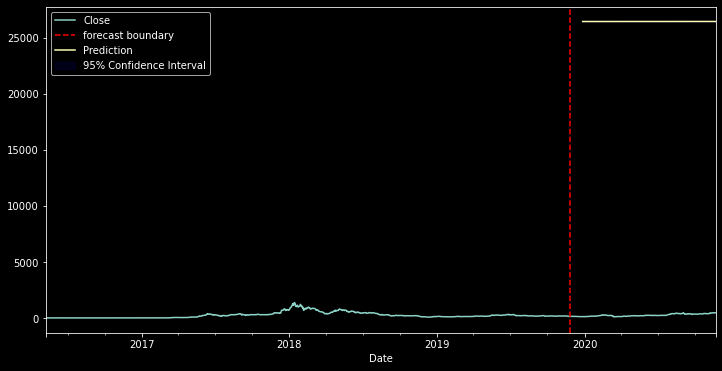

In [ ]:
fig = plt.figure(figsize = (12, 6))

data["Close"].plot.line()
plt.axvline(x=cutoff, c="red", ls="--", label="forecast boundary");
plt.fill_between(x=data_te[30:].index, y1=lbs, y2=ubs, color="b", alpha=0.1, label="95% Confidence Interval")
plt.plot(data_te[30:].index, meds, label="Prediction");
plt.legend(loc="upper left");
# plt.suptitle(f"ARIMA {optimal[0][0]} Prediction Result (r2 score: {r2}")

In [ ]:
!nvidia-smi

Sat Aug  7 03:51:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------